<a href="https://colab.research.google.com/github/JNPauli/Protect_app_master_thesis/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Import X and y

In [3]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [4]:
os.chdir('/content/drive/MyDrive/Thesis')

In [5]:
y = np.load('train_con.npy')

In [6]:
y_ = y[0:10000]
y_frames = y[14276:]

In [7]:
y_all = np.concatenate((y_,y_frames))

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [8]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [9]:
X = np.load('X_npy.npy')

In [10]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X,y_,test_size=0.2,random_state=42)

In [11]:
del X,y_
gc.collect()

22

In [12]:
X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_,y_train_, test_size = 0.2,random_state=42)

In [13]:
X_frames = np.load('frames_npy.npy')

In [14]:
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_frames,y_frames,test_size=0.2,random_state=42)

In [15]:
del X_frames,y_frames
gc.collect()

11

In [16]:
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(X_train_f,y_train_f, test_size = 0.2,random_state=42)

Converting X to appropriate Datatype...

In [17]:
X_tensor_train = torch.from_numpy(X_train_)
del X_train_
gc.collect()
X_tensor_test = torch.from_numpy(X_test_)
del X_test_
gc.collect()
X_tensor_val = torch.from_numpy(X_val_)
del X_val_
gc.collect()

y_tensor_train = torch.from_numpy(y_train_)
del y_train_
gc.collect()
y_tensor_test = torch.from_numpy(y_test_)
del y_test_
gc.collect()
y_tensor_val = torch.from_numpy(y_val_)
del y_val_
gc.collect()

0

In [18]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)

y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)
y_tensor_val = y_tensor_val.type(torch.LongTensor)

<ipython-input-18-3ff54277ee2f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-18-3ff54277ee2f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
<ipython-input-18-3ff54277ee2f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_val = torch.tensor(X_tensor_val,dtype=torch.float32)


In [19]:
X_tensor_train_ = torch.from_numpy(X_train_f)
del X_train_f
gc.collect()
X_tensor_test_ = torch.from_numpy(X_test_f)
del X_test_f
gc.collect()
X_tensor_val_ = torch.from_numpy(X_val_f)
del X_val_f
gc.collect()

y_tensor_train_ = torch.from_numpy(y_train_f)
del y_train_f
gc.collect()
y_tensor_test_ = torch.from_numpy(y_test_f)
del y_test_f
gc.collect()
y_tensor_val_ = torch.from_numpy(y_val_f)
del y_val_f
gc.collect()

0

In [20]:
X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)
X_tensor_val = torch.tensor(X_tensor_val_,dtype=torch.float32)

y_tensor_train_ = y_tensor_train_.type(torch.LongTensor)
y_tensor_test_ = y_tensor_test_.type(torch.LongTensor)
y_tensor_val = y_tensor_val_.type(torch.LongTensor)

<ipython-input-20-daeb6c2c99f4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
<ipython-input-20-daeb6c2c99f4>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)
<ipython-input-20-daeb6c2c99f4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_val = torch.tensor(X_tensor_val_,dtype=torch.float32)


In [21]:
X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_),0)
X_tensor_test = torch.cat((X_tensor_test,X_tensor_test_),0)
X_tensor_val = torch.cat((X_tensor_val, X_tensor_val_),0)

y_tensor_train = torch.cat((y_tensor_train,y_tensor_train_),0)
y_tensor_test = torch.cat((y_tensor_test,y_tensor_test_),0)
y_tensor_val = torch.cat((y_tensor_val,y_tensor_val_),0)

In [22]:
print('training shape X is {}, validation shape is {}, test shape X is{}'.format(X_tensor_train.shape,X_tensor_val.shape,X_tensor_test.shape))

training shape X is torch.Size([11102, 1, 224, 224]), validation shape is torch.Size([2352, 1, 224, 224]), test shape X istorch.Size([3470, 1, 224, 224])


To get max value of classN-1

In [23]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1
y_tensor_val = y_tensor_val-1

Setup custom dataset class

In [24]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y

In [25]:
dataset_train = SimpleDataset(X_tensor_train,y_tensor_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = SimpleDataset(X_tensor_val,y_tensor_val)
dataloader_val = DataLoader(dataset_val,batch_size=32)

dataset_test = SimpleDataset(X_tensor_test,y_tensor_test)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


Sanity Check: Is the network not working, because there is a bug in the code? Evaluate with MNIST

Setting up the CNN.

In [65]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        #self.conv2 = nn.Conv2d(32,64,3) #remove layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(394272, 128)
        #self.fc2 = nn.Linear(128,10)
        self.Arousal = nn.Linear(128,10) #3
        self.Valence = nn.Linear(128,10)
        self.Dominance = nn.Linear(128,10)
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.fc2(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance 
#removed 

In [66]:
SalienceNet = CNN()
SalienceNet.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=394272, out_features=128, bias=True)
  (Arousal): Linear(in_features=128, out_features=10, bias=True)
  (Valence): Linear(in_features=128, out_features=10, bias=True)
  (Dominance): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [28]:
class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin
  
  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2 
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()

In [29]:
cont_loss = ContinuousLoss_L2()

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,dataloader_val,
          epoch=100, learning_rate=0.000001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    train_loss = []
    val_loss = []
    train_epoch_loss = []
    val_epoch_loss = []
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)
        val_loop = tqdm(dataloader_val)
        total,correct = 0,0
        net.to(device)   
        net.train()
        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())
           
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance

      
            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update
            
            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")
        
        train_epoch_loss.append((np.array(train_loss).mean()))
        net.eval()
        val_total,val_correct = 0,0
        val_acc = []
        for data, labels in dataloader_val:
            data, labels = data.to(device), labels.to(device)

            Arousal_v,Valence_v,Dominance_v = net(data.float())
          
           
            loss_arousal_v = loss_fn(Arousal_v,labels[:,0])
            loss_valence_v = loss_fn(Valence_v,labels[:,1])
            loss_dominance_v = loss_fn(Dominance_v,labels[:,2])
            val_l=loss_arousal_v+loss_valence_v+loss_dominance_v
        
            val_loss.append(val_l.item())

        val_epoch_loss.append((np.array(val_loss).mean()))


    return train_loss,train_epoch_loss,val_loss,val_epoch_loss


In [32]:
def test(net,loss_fn,dataloader_test):
  net.eval()
  test_loss = []
  test_total,test_correct = 0,0
  test_acc = []
  test_loop = tqdm(dataloader_test)
  i=0
  for batch, (data, labels) in enumerate(test_loop):
      print('testing...')

      data, labels = data.to(device), labels.to(device)
      arousal,valence,dominance = net(data.float())

      arousal_t = loss_fn(arousal,labels[:,0])
      valence_t = loss_fn(valence,labels[:,1])
      dominance_t = loss_fn(dominance,labels[:,2])

      test_l = arousal_t+valence_t+dominance_t

      test_loss.append(test_l.item())
      test_loop.set_description(f"Batch [{i+1}/{batch}]")
      i=+1

        #test_total += labels.size(0)
        #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()
        
    #test_acc.append(test_correct/test_total)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc)
  return test_loss

In [33]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [34]:
import matplotlib.pyplot as plt

In [35]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})''')) 

<IPython.core.display.Javascript object>

In [69]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,val_loss,val_epoch_loss=train(net=SalienceNet,loss_fn=criterion,dataloader_train=dataloader_train,
                  dataloader_val=dataloader_val,epoch=25)




  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/347 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]


  0%|          | 0/74 [00:16<?, ?it/s]


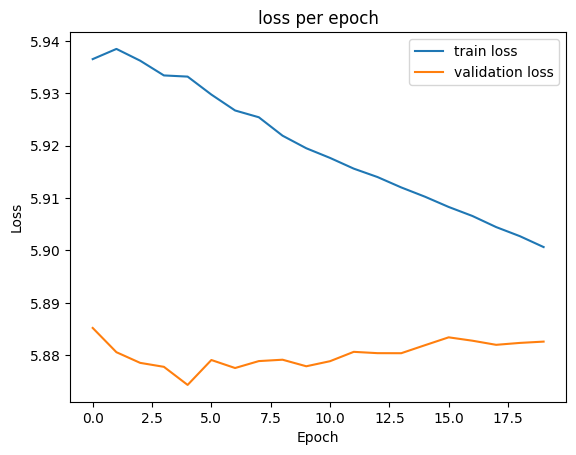

In [70]:
plt.plot(train_epoch_loss, label = 'train loss')
plt.plot(val_epoch_loss, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('loss per epoch')
plt.legend()
plt.show()

In [38]:
test_loss = test(net=SalienceNet,loss_fn=criterion,dataloader_test=dataloader_test)

Batch [2/3]:   3%|▎         | 3/109 [00:00<00:04, 22.88it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/8]:   8%|▊         | 9/109 [00:00<00:04, 23.91it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/13]:  11%|█         | 12/109 [00:00<00:04, 23.77it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/19]:  17%|█▋        | 18/109 [00:00<00:03, 24.03it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/23]:  22%|██▏       | 24/109 [00:01<00:03, 23.98it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/28]:  25%|██▍       | 27/109 [00:01<00:03, 23.51it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/33]:  30%|███       | 33/109 [00:01<00:03, 23.45it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/38]:  36%|███▌      | 39/109 [00:01<00:02, 23.54it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/44]:  39%|███▊      | 42/109 [00:01<00:02, 23.39it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/48]:  44%|████▍     | 48/109 [00:02<00:02, 23.64it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/53]:  50%|████▉     | 54/109 [00:02<00:02, 23.31it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/58]:  52%|█████▏    | 57/109 [00:02<00:02, 23.32it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/63]:  58%|█████▊    | 63/109 [00:02<00:01, 23.53it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/68]:  63%|██████▎   | 69/109 [00:02<00:01, 23.68it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/73]:  66%|██████▌   | 72/109 [00:03<00:01, 23.82it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/78]:  72%|███████▏  | 78/109 [00:03<00:01, 23.94it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/83]:  77%|███████▋  | 84/109 [00:03<00:01, 23.96it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/88]:  80%|███████▉  | 87/109 [00:03<00:00, 23.75it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/93]:  85%|████████▌ | 93/109 [00:03<00:00, 23.94it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/98]:  91%|█████████ | 99/109 [00:04<00:00, 23.89it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/104]:  96%|█████████▋| 105/109 [00:04<00:00, 24.02it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/108]: 100%|██████████| 109/109 [00:04<00:00, 23.82it/s]

testing...
testing...
testing...
testing...


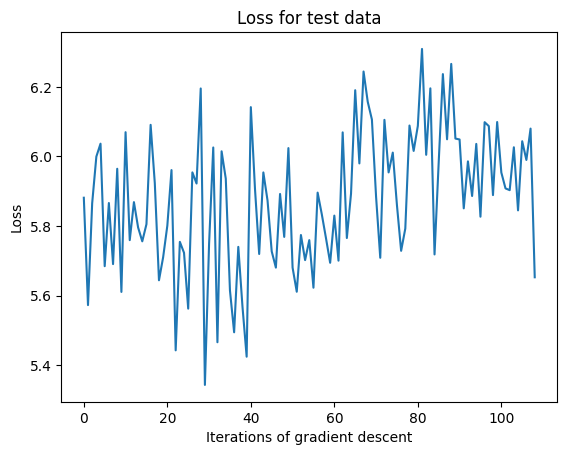

In [39]:
plt.plot(test_loss)
plt.xlabel('Iterations of gradient descent')
plt.ylabel('Loss')
plt.title('Loss for test data')
plt.show()